In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from tqdm import tqdm
import spacy
from nltk.util import ngrams
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

from transformers import pipeline

# lemmatize = spacy.load("en_core_web_sm")


c:\Users\lukgr\miniconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Load data

In [5]:
data = pd.read_json("data/putin_complete.json")

## Preprocessing

In [6]:
stop_words = set(stopwords.words('english'))

In [7]:
transcripts = np.array(data["transcript_filtered"])
dates = data["date"].reset_index(drop=True)
punctuation = [".", ",", "?", "!", ":", "`", "'", "(", ")", "[", "]", "/", '’', "-", "’s", "\"", ";", "i", " ", "–", "%", "*", "...", "…"]
lemmatize = spacy.load("en_core_web_sm")
transcripts_processed = {}

for id in tqdm(range(len(transcripts)), "Removing stop words..."):
    curr_date = dates[id].strftime('%Y-%m')
    speech_from_date = [
        w.lemma_.lower() for w in lemmatize(transcripts[id]) if not (w.lemma_ in stop_words or w.lemma_.lower() in punctuation or " " in w.lemma_)
    ]
    if curr_date not in transcripts_processed.keys():
        transcripts_processed[curr_date] = []
    if len(speech_from_date) > 0:
        transcripts_processed[curr_date].append(speech_from_date)


Removing stop words...: 100%|██████████| 9838/9838 [12:24<00:00, 13.21it/s] 


## EDA & Some Analysis

In [8]:
all_words = []
token_counts = []
speeches_count = 0
for k, v in transcripts_processed.items():
    if v:
        for speech in v:
            all_words += speech
            token_counts.append(len(speech))
            speeches_count += 1

word_frequencies = pd.Series(all_words).value_counts()

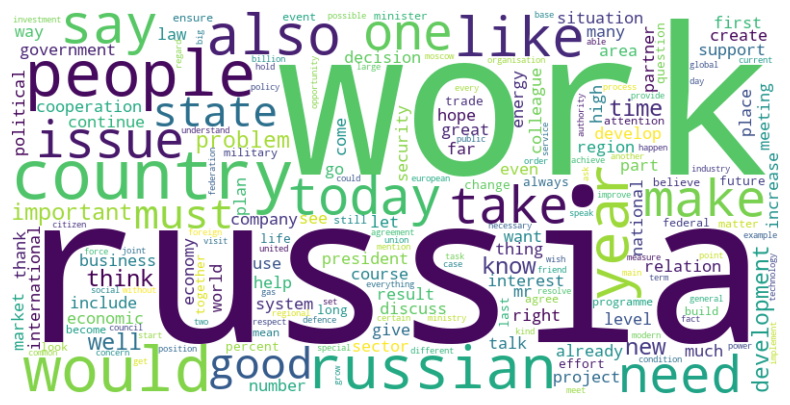

In [9]:
# # The most common terms in the corpus showed as a word cloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [10]:
print(f"Average length of monthly speeches in token count: {int(np.sum(token_counts) / speeches_count)}")

Average length of monthly speeches in token count: 489


In [11]:
print(f"Average token length: {np.round(np.mean([len(word) for word in all_words]), 2)}")

Average token length: 6.41


In [12]:
all_ngrams = []

for k, v in transcripts_processed.items():
    for speech in v:
        all_ngrams += list(ngrams(speech, 5))

In [13]:
def find_words_near_poland(ngrams):
    words_near_poland = []
    for ngram in ngrams:
        if "poland" in ngram or "polish" in ngram:
            for word in ngram:
                if not word.__eq__("poland") and not word.__eq__("polish"):
                    words_near_poland.append(word)
    
    return words_near_poland

In [14]:
# Words used near word Poland using N-grams (which words are in N-grams along with words 'poland' and 'polish'.)
pd.Series(find_words_near_poland(all_ngrams)).value_counts()[:10]

russian      229
russia       227
relation     156
people       151
germany      128
minister     123
romania      119
republic     119
country      117
president    112
Name: count, dtype: int64

### Animation of most common terms in speeches in each month

In [15]:
# fig, ax = plt.subplots(figsize=(10, 6))

# def update(frame):
#     curr_key = list(transcripts_processed.keys())[frame]
#     curr_speeches = []
#     for speech in transcripts_processed[curr_key]:
#         curr_speeches += speech
#     counts = pd.Series(curr_speeches).value_counts()
#     ax.clear()
#     plt.barh(counts[:10].index, counts[:10].values)
#     ax.set_xlabel("Values")
#     ax.set_ylabel("Categories")
#     ax.set_title(f"Counts for month: {curr_key}")
#     ax.set_xlim(0, 300)

# num_frames = len(transcripts_processed.keys())
# ani = FuncAnimation(fig, update, frames=num_frames, repeat=True, interval=1000)

# ani.save("counts.gif", writer='pillow')

In [16]:
def get_token_encounters(token):
    encounters = []
    dates = []
    for k, v in transcripts_processed.items():
        dates.append(k)
        counts_for_month = []
        for speech in v:
            counts = pd.Series(speech).value_counts()
            try:
                counts_for_month.append(counts[token])
            except:
                counts_for_month.append(0)
        encounters.append(sum(counts_for_month))
    
    return encounters, dates

def plot_counts(tokens):
    encounters, dates = get_token_encounters(tokens[0])
    for token in tokens[1:]:
        encounters_token, _ = get_token_encounters(token)
        encounters = [encounters[i] + encounters_token[i] for i in range(len(encounters))]
    plt.plot(dates, encounters, color="royalblue")
    plt.xlabel("Date")
    plt.ylabel("Counts")
    plt.title(f"Count of mentions about {tokens}")
    plt.xticks(rotation=45, ticks=range(0, len(dates), 12))
    threshold = np.quantile(encounters, 0.99)
    for i in range(len(encounters)):
        if encounters[i] > threshold:
            plt.text(i-20, encounters[i]+max(encounters)/50, dates[i], color='darkblue', rotation=45)
    # plt.ylim(0, max(encounters) + max(encounters)/5)
    plt.ylim(0, 320)
    plt.show() 

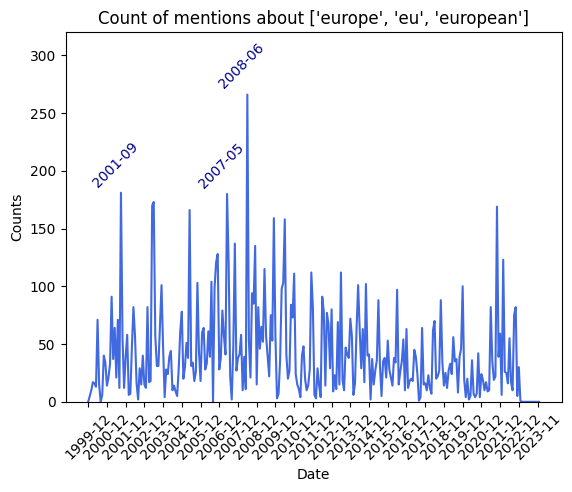

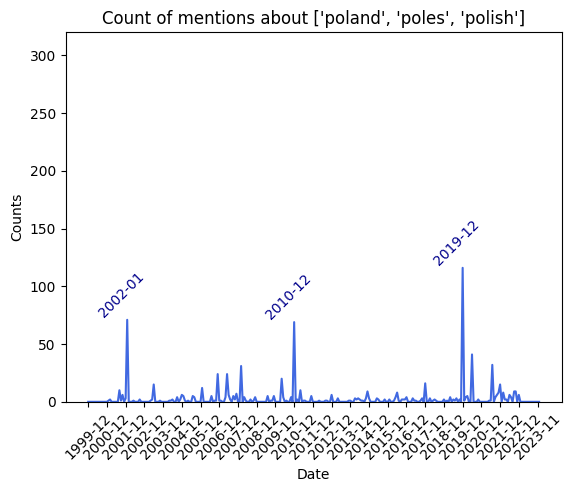

In [17]:
plot_counts(["europe", "eu", "european"])
# plot_counts(["warsaw"])
plot_counts(["poland", "poles", "polish"])

In [18]:
speeches_processed = {}
for date, value in transcripts_processed.items():
    speeches_processed[date] = []
    for speech in value:
        speeches_processed[date].append(" ".join(speech))

all_speeches = []
for k, v in speeches_processed.items():
    for speech in v:
        all_speeches.append(speech)

vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(all_speeches)

In [19]:
tfidf_dict = {}
for ele1, ele2 in zip(vectorizer.get_feature_names_out(), vectorizer.idf_):
   if ele2 < 5.5:
      tfidf_dict[ele1] = np.round(ele2, 5)

In [20]:
# Terms with highest TF-IDF scores (first 100 terms with highest scores were filtered 
# since even in processed texts there are some pointless tokens which shows for instance once in a whole corpus)

tfidf_values = list(tfidf_dict.values())
tfidf_keys = list(tfidf_dict.keys())
sorting_perm = sorted(range(len(tfidf_values)), key=lambda i: tfidf_values[i])

print(np.array(tfidf_values)[sorting_perm])
print(f"Terms with highest TF-IDF: {np.array(tfidf_keys)[sorting_perm][-20:]}")

[1.27392 1.31138 1.3276  ... 5.49724 5.49724 5.49724]
Terms with highest TF-IDF: ['outlet' 'paramount' 'retail' 'sailor' 'satisfactory' 'summarise' 'tear'
 'whenever' 'yamal' 'brussels' 'complicate' 'contractual' 'crimean'
 'disarmament' 'energetically' 'entrepreneurial' 'flag' 'prior'
 'unnecessary' 'vivid']


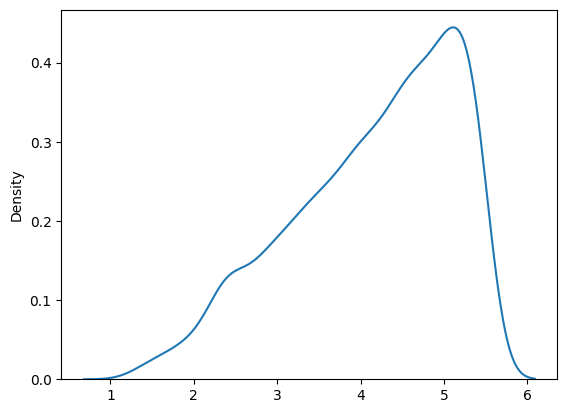

In [21]:
# Distribution of TF-IDF scores in corpus used to find a cut-off to filer the highest scores

sns.kdeplot(np.array(tfidf_values)[sorting_perm])
plt.show()

In [22]:
split_speeches_for_bert = {}
words_list = ["europe", "eu", "european"]
chunk_size = 256

for date, value in transcripts_processed.items():
    split_speeches_for_bert[date] = []
    for speech in value:
        if any(pol_word in speech for pol_word in words_list):
            split_speeches_for_bert[date].append([speech[i:i + chunk_size] for i in range(0, len(speech), chunk_size)])

In [23]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [24]:
sentiments_in_time = {}

for date, val in tqdm(split_speeches_for_bert.items(), "Predicting sentiment..."):
    if len(val) == 0:
        continue
    for speech in val:
        speech_sentiments = []
        for split in speech:
            if len(split) > 100:
                inputs = tokenizer(" ".join(split), return_tensors="pt")
                with torch.no_grad():
                    speech_sentiments.append(model(**inputs).logits[0])
        if len(speech_sentiments) == 0:
            continue
        stacked_tensors = torch.stack(speech_sentiments)
        mean_x = torch.mean(stacked_tensors[:, 0])
        mean_y = torch.mean(stacked_tensors[:, 1])
        final_sentiment = model.config.id2label[0 if mean_x > mean_y else 1]

        if not date in list(sentiments_in_time.keys()):
            sentiments_in_time[date] = []
        sentiments_in_time[date].append(final_sentiment)

Predicting sentiment...: 100%|██████████| 290/290 [09:28<00:00,  1.96s/it]


In [25]:
sentiment_dates = []
positive_sentiment_counts = []
negative_sentiment_counts = []

for date, sentiments in sentiments_in_time.items():
    sentiment_dates.append(date)
    pos_count = 0
    neg_count = 0
    for sentiment in sentiments:
        if sentiment.__eq__("POSITIVE"):
            pos_count += 1
        else:
            neg_count += 1
    positive_sentiment_counts.append(pos_count)
    negative_sentiment_counts.append(neg_count)

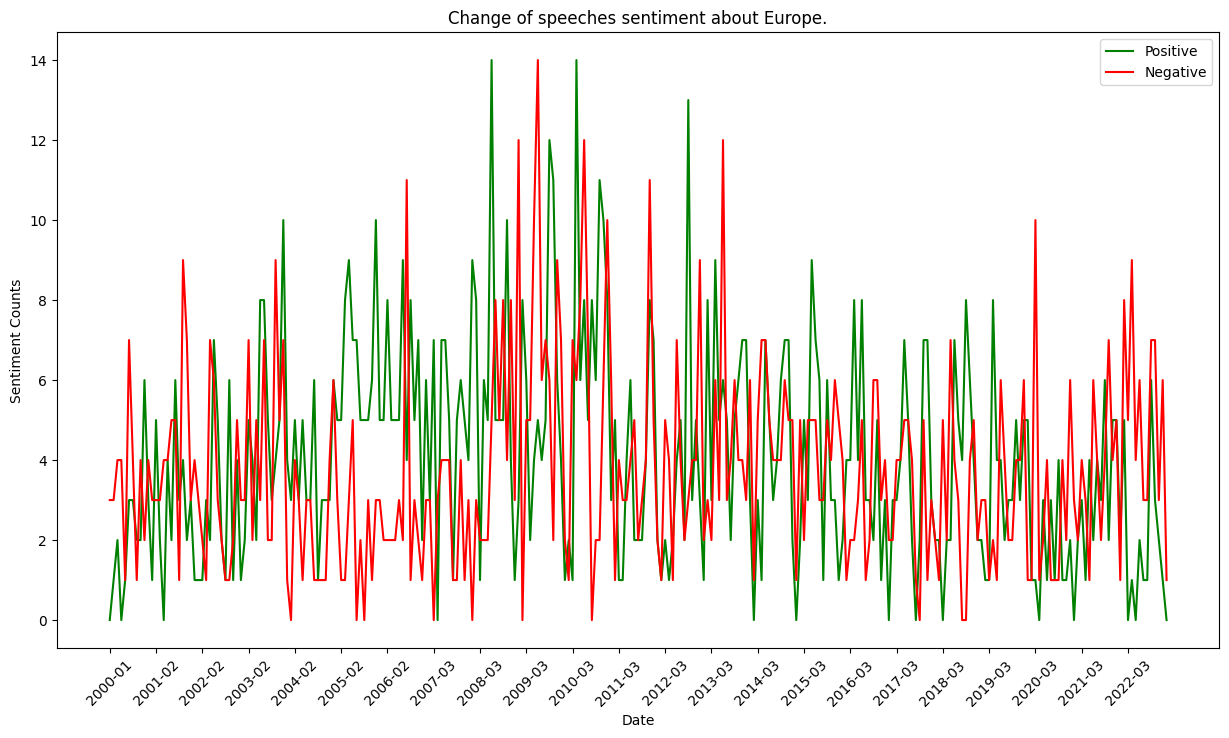

In [26]:
plt.figure(figsize=(15, 8))
plt.plot(sentiment_dates, positive_sentiment_counts, color="green", label="Positive")
plt.plot(sentiment_dates, negative_sentiment_counts, color="red", label="Negative")
plt.xlabel("Date")
plt.ylabel("Sentiment Counts")
plt.legend()
plt.title(f"Change of speeches sentiment about Europe.")
plt.xticks(rotation=45, ticks=range(0, len(sentiment_dates), 12))
plt.show()

In [27]:
nlp = spacy.load("en_core_web_sm")
polish_aspects = {}
words_list = ["poland", "polish", "poles"]
chunk_range = 5

for date, value in tqdm(transcripts_processed.items(), "Processing..."):
    polish_aspects[date] = []
    for speech in value:
        if any(word in speech for word in words_list):
            chunks = []
            for i in range(len(speech)):
                if speech[i] in words_list:
                    chunks.append(" ".join(speech[i-chunk_range:i+chunk_range+1]))     

            for polish_chunk in chunks:
                polish_aspects[date].append(polish_chunk)

Processing...: 100%|██████████| 290/290 [00:00<00:00, 1312.21it/s]


In [30]:
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

Device set to use cpu


In [31]:
chunk_dates = []
chunk_positive_sentiments = []
chunk_negative_sentiments = []

for date, value in tqdm(polish_aspects.items(), "Processing..."):
    chunk_dates.append(date)

    if len(value) > 0:
        pos_count = 0
        neg_count = 0
        for chunk in value:
            chunk_sentiment = sentiment_analysis(chunk)[0]
            if chunk_sentiment["label"].__eq__("POSITIVE"):
                pos_count += 1
            elif chunk_sentiment["label"].__eq__("NEGATIVE"):
                neg_count += 1
        chunk_negative_sentiments.append(neg_count)
        chunk_positive_sentiments.append(pos_count)
    else:
        chunk_positive_sentiments.append(0)
        chunk_negative_sentiments.append(0)

Processing...: 100%|██████████| 290/290 [01:01<00:00,  4.70it/s]


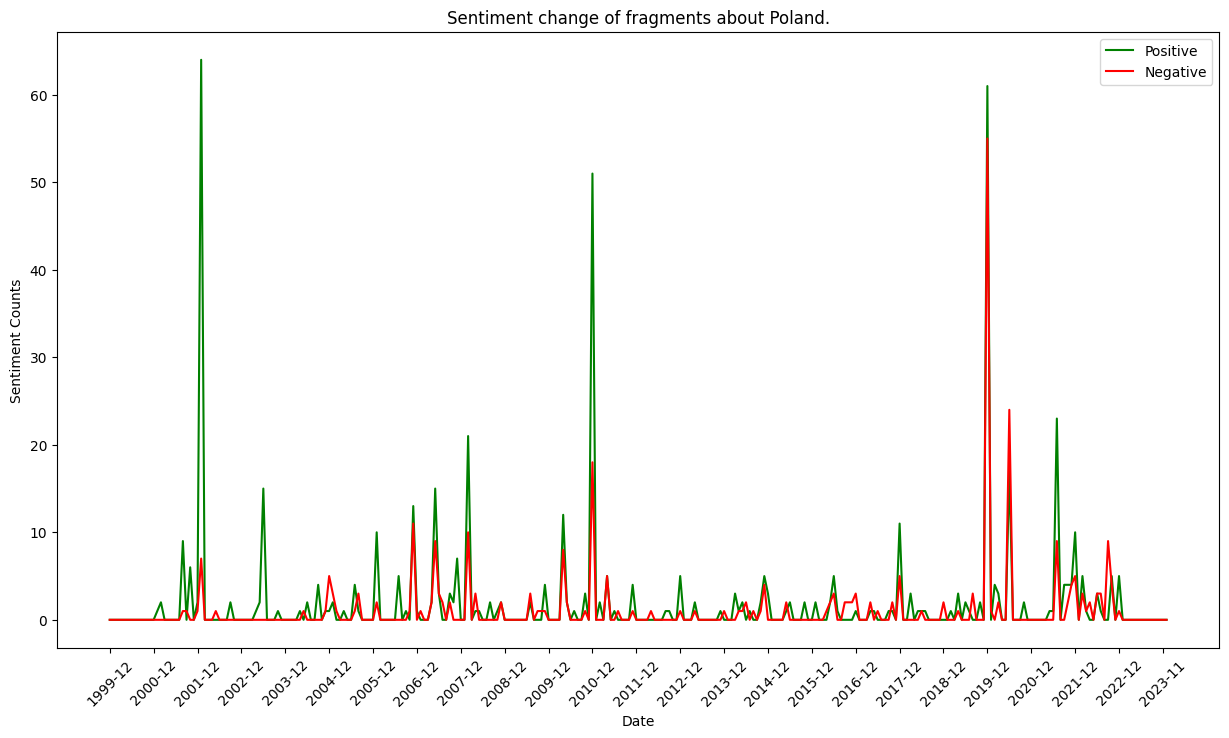

In [32]:
plt.figure(figsize=(15, 8))
plt.plot(chunk_dates, chunk_positive_sentiments, color="green", label="Positive")
plt.plot(chunk_dates, chunk_negative_sentiments, color="red", label="Negative")
plt.xlabel("Date")
plt.ylabel("Sentiment Counts")
plt.legend()
plt.title(f"Sentiment change of fragments about Poland.")
plt.xticks(rotation=45, ticks=range(0, len(chunk_dates), 12))
plt.show()

In [33]:
chunk_data = pd.DataFrame({
    'Date': pd.to_datetime(chunk_dates, format='%Y-%m'),
    'value_pos': chunk_positive_sentiments,
    'value_neg': chunk_negative_sentiments
})

chunk_data['Year'] = chunk_data['Date'].dt.year
chunk_data['Quarter'] = (chunk_data['Date'].dt.month) // 4 + 1

grouped = chunk_data.groupby(['Year', 'Quarter'])[['value_pos', 'value_neg']].mean().reset_index()

grouped['Quarter_Label'] = grouped['Year'].astype(str) + "-Q" + grouped['Quarter'].astype(str)
dates_list = grouped['Quarter_Label'].tolist()
pos_values_list = grouped['value_pos'].tolist()
neg_values_list = grouped['value_neg'].tolist()

C:\Users\lukgr\AppData\Local\Temp\ipykernel_8956\4242601451.py:5: RuntimeWarning: invalid value encountered in divide
  positive_ratios = pos_values_list / total_sentiments
C:\Users\lukgr\AppData\Local\Temp\ipykernel_8956\4242601451.py:6: RuntimeWarning: invalid value encountered in divide
  negative_ratios = neg_values_list / total_sentiments


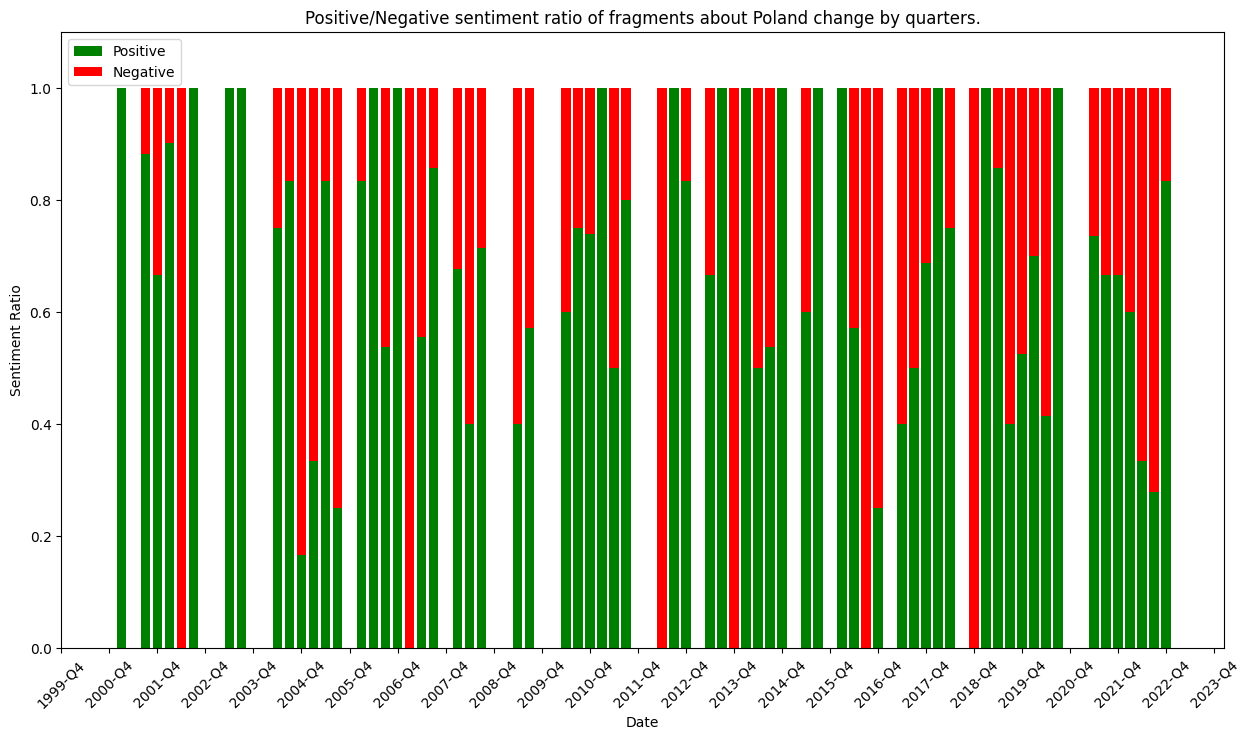

In [34]:
pos_values_list = np.array(pos_values_list)
neg_values_list = np.array(neg_values_list)

total_sentiments = pos_values_list + neg_values_list
positive_ratios = pos_values_list / total_sentiments
negative_ratios = neg_values_list / total_sentiments

plt.figure(figsize=(15, 8))
plt.bar(dates_list, positive_ratios, color="green", label="Positive")
plt.bar(dates_list, negative_ratios, bottom=positive_ratios, color="red", label="Negative")
plt.xlabel("Date")
plt.ylabel("Sentiment Ratio")
plt.legend(loc="upper left")
plt.ylim(0, 1.1)
plt.title(f"Positive/Negative sentiment ratio of fragments about Poland change by quarters.")
plt.xticks(rotation=45, ticks=range(0, len(dates_list), 4))
plt.show()

### ABSA using pretrained models

In [35]:
from transformers import pipeline
import spacy

nlp = spacy.load("en_core_web_sm")
sentiment_analyzer = pipeline("sentiment-analysis")
words_list = ["poland", "polish", "poles"]

def extract_aspects_and_sentiment(speech, words_list):
    aspects_sentiments = []
    doc = nlp(" ".join(speech))
    
    for sent in doc.sents:
        if any(word.lower() in sent.text.lower() for word in words_list):
            aspects = [chunk.text for chunk in sent.noun_chunks if any(word.lower() in chunk.text.lower() for word in words_list)]
            
            for aspect in aspects:
                sentiment = sentiment_analyzer(aspect)
                aspects_sentiments.append({"aspect": aspect, "sentiment": sentiment})
    return aspects_sentiments

polish_aspects = {}
for date, speeches in tqdm(transcripts_processed.items(), "Processing speeches..."):
    polish_aspects[date] = []
    for speech in speeches:
        aspects_sentiments = extract_aspects_and_sentiment(speech, words_list)
        polish_aspects[date].extend(aspects_sentiments)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Processing speeches...: 100%|██████████| 290/290 [05:43<00:00,  1.18s/it]


In [36]:
aspects_with_scores = {}

for date, aspects in polish_aspects.items():
    for aspect in aspects:
        aspect_name = aspect["aspect"]
        aspect_label = aspect["sentiment"][0]["label"]

        if aspect_name not in aspects_with_scores:
            aspects_with_scores[aspect_name] = [aspect_label]
        else:
            aspects_with_scores[aspect_name].append(aspect_label)

In [37]:
common_aspects = {}

for aspect, labels in aspects_with_scores.items():
    if len(labels) > 1:
        common_aspects[aspect] = labels

In [38]:
# Common extracted aspects (All positive)

for aspect in common_aspects.keys():
    print(aspect)

relation poland
russia poland
poles
poland
polish president
polish territory
polish people
polish colleague
russian polish relation
polish friend
polish government
polish foreign minister
poland romania


In [39]:
pos_all_words_from_aspects = []
neg_all_words_from_aspects = []

for date, aspects in polish_aspects.items():
    for aspect in aspects:
        aspect_name = aspect["aspect"]
        aspect_label = aspect["sentiment"][0]["label"]
        for word in aspect_name.split(" "):
            if word not in words_list:
                if aspect_label == "POSITIVE":
                    pos_all_words_from_aspects.append(word)
                if aspect_label == "NEGATIVE":
                    neg_all_words_from_aspects.append(word)

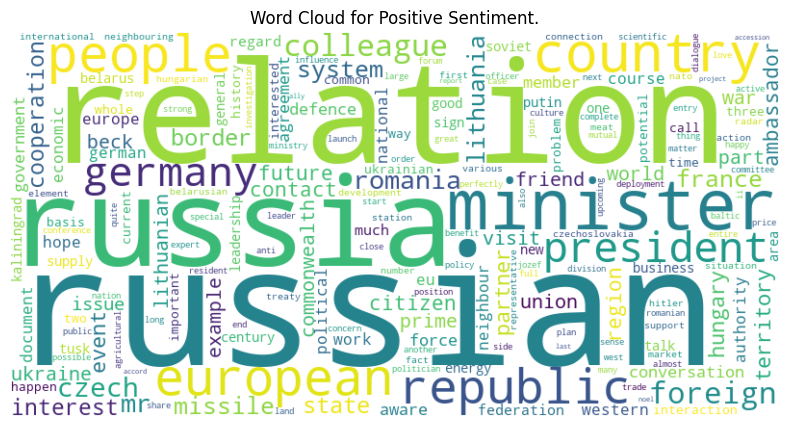

In [40]:
word_frequencies = pd.Series(pos_all_words_from_aspects).value_counts()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Positive Sentiment.")
plt.show()

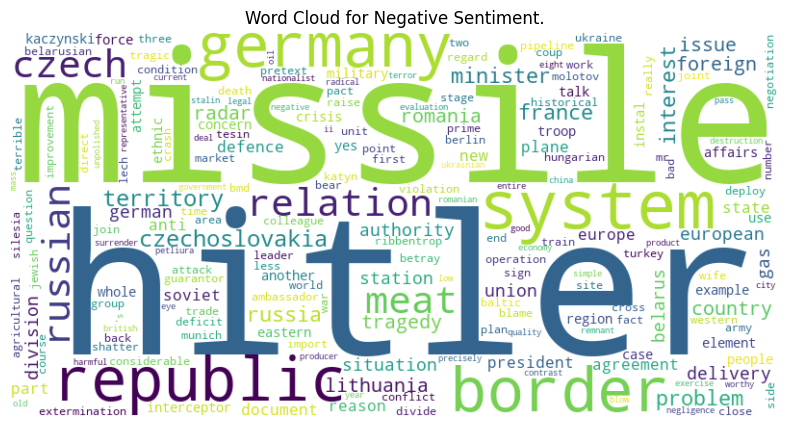

In [41]:
word_frequencies = pd.Series(neg_all_words_from_aspects).value_counts()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Negative Sentiment.")
plt.show()

### Predicting events based on sentiment change

In [42]:
train_dates = [
    '1999-12', '2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07', 
    '2000-08', '2000-09', '2000-10', '2000-11', '2000-12', '2001-01', '2001-02', '2001-03', 
    '2001-04', '2001-05', '2001-06', '2001-07', '2001-08', '2001-09', '2001-10', '2001-11', 
    '2001-12', '2002-01', '2002-02', '2002-03', '2002-04', '2002-05', '2002-06', '2002-07', 
    '2002-08', '2002-09', '2002-10', '2002-11', '2002-12', '2003-01', '2003-02', '2003-03', 
    '2003-04', '2003-05', '2003-06', '2003-07', '2003-08', '2003-09', '2003-10', '2003-11', 
    '2003-12', '2004-01', '2004-02', '2004-03', '2004-04', '2004-05', '2004-06', '2004-07', 
    '2004-08', '2004-09', '2004-10', '2004-11', '2004-12', '2005-01', '2005-02', '2005-03', 
    '2005-04', '2005-05', '2005-06', '2005-07', '2005-08', '2005-09', '2005-10', '2005-11', 
    '2005-12', '2006-01', '2006-02', '2006-03', '2006-04', '2006-05', '2006-06', '2006-07', 
    '2006-08', '2006-09', '2006-10', '2006-11', '2006-12', '2007-01', '2007-02', '2007-03', 
    '2007-04', '2007-05', '2007-06', '2007-07', '2007-08', '2007-09', '2007-10', '2007-11', 
    '2007-12', '2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', 
    '2008-08', '2008-09', '2008-10', '2008-11', '2008-12', '2009-01', '2009-02', '2009-03', 
    '2009-04', '2009-05', '2009-06', '2009-07', '2009-08', '2009-09', '2009-10', '2009-11', 
    '2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', 
    '2010-08', '2010-09', '2010-10', '2010-11', '2010-12', '2011-01', '2011-02', '2011-03', 
    '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', 
    '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', 
    '2012-08', '2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02', '2013-03', 
    '2013-04', '2013-05', '2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', 
    '2013-12', '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', 
    '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02', '2015-03', 
    '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', 
    '2015-12'
]

positive_events_list = [0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

negative_events_list = [0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [43]:
def preprocess_data(data):
    df = pd.DataFrame(data)
    df['dates'] = pd.to_datetime(df['dates'])

    df['positive_sentiments_lag_1'] = df['positive_sentiments'].shift(1).fillna(0)
    df['negative_sentiments_lag_1'] = df['negative_sentiments'].shift(1).fillna(0)
    df['positive_sentiments_lag_2'] = df['positive_sentiments'].shift(2).fillna(0)
    df['negative_sentiments_lag_2'] = df['negative_sentiments'].shift(2).fillna(0)
    df['positive_sentiments_lag_3'] = df['positive_sentiments'].shift(3).fillna(0)
    df['negative_sentiments_lag_3'] = df['negative_sentiments'].shift(3).fillna(0)

    df['rolling_mean_positive_3'] = df['positive_sentiments'].rolling(window=3).mean().fillna(0)
    df['rolling_mean_negative_3'] = df['negative_sentiments'].rolling(window=3).mean().fillna(0)

    return df

def assign_data(df):
    df['positive_event_next'] = df['positive_event_occurred'].shift(-1)
    df['negative_event_next'] = df['negative_event_occurred'].shift(-1)

    df = df.iloc[:-1]

    X = df[['positive_sentiments', 'negative_sentiments',
            'positive_sentiments_lag_1', 'negative_sentiments_lag_1',
            'positive_sentiments_lag_2', 'negative_sentiments_lag_2',
            'positive_sentiments_lag_3', 'negative_sentiments_lag_3',
            'rolling_mean_positive_3', 'rolling_mean_negative_3']]
    y_positive = df['positive_event_next']
    y_negative = df['negative_event_next']
    
    return X, y_positive, y_negative

In [44]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

data = {
    'dates': train_dates,
    'positive_sentiments': chunk_positive_sentiments[:len(train_dates)],
    'negative_sentiments': chunk_negative_sentiments[:len(train_dates)],
    'positive_event_occurred': positive_events_list,
    'negative_event_occurred': negative_events_list,
}

df = preprocess_data(data)
X, y_positive, y_negative = assign_data(df)

smote = SMOTE(k_neighbors=4, random_state=42)
X_train_pos_sm, y_train_pos_sm = smote.fit_resample(X, y_positive)
smote = SMOTE(k_neighbors=4, random_state=42)
X_train_neg_sm, y_train_neg_sm = smote.fit_resample(X, y_negative)


X_train, X_test, y_train_positive, y_test_positive = train_test_split(
    X, y_positive, test_size=0.2, random_state=42, shuffle=False)
X_train, X_test, y_train_negative, y_test_negative = train_test_split(
    X, y_negative, test_size=0.2, random_state=42, shuffle=False)

positive_model = XGBClassifier(n_estimators=10, max_depth=2, learning_rate=1, objective='binary:logistic')
negative_model = XGBClassifier(n_estimators=10, max_depth=2, learning_rate=1, objective='binary:logistic')

positive_model.fit(X_train_pos_sm, y_train_pos_sm)
negative_model.fit(X_train_neg_sm, y_train_neg_sm)

y_pred_positive = positive_model.predict(X_test)
y_pred_negative = negative_model.predict(X_test)

In [45]:
full_data = {
    'dates': chunk_dates,
    'positive_sentiments': chunk_positive_sentiments,
    'negative_sentiments': chunk_negative_sentiments,
    'positive_event_occurred': chunk_positive_sentiments,
    'negative_event_occurred': chunk_positive_sentiments,
}

full_df = preprocess_data(full_data)
full_X, _, _ = assign_data(full_df)

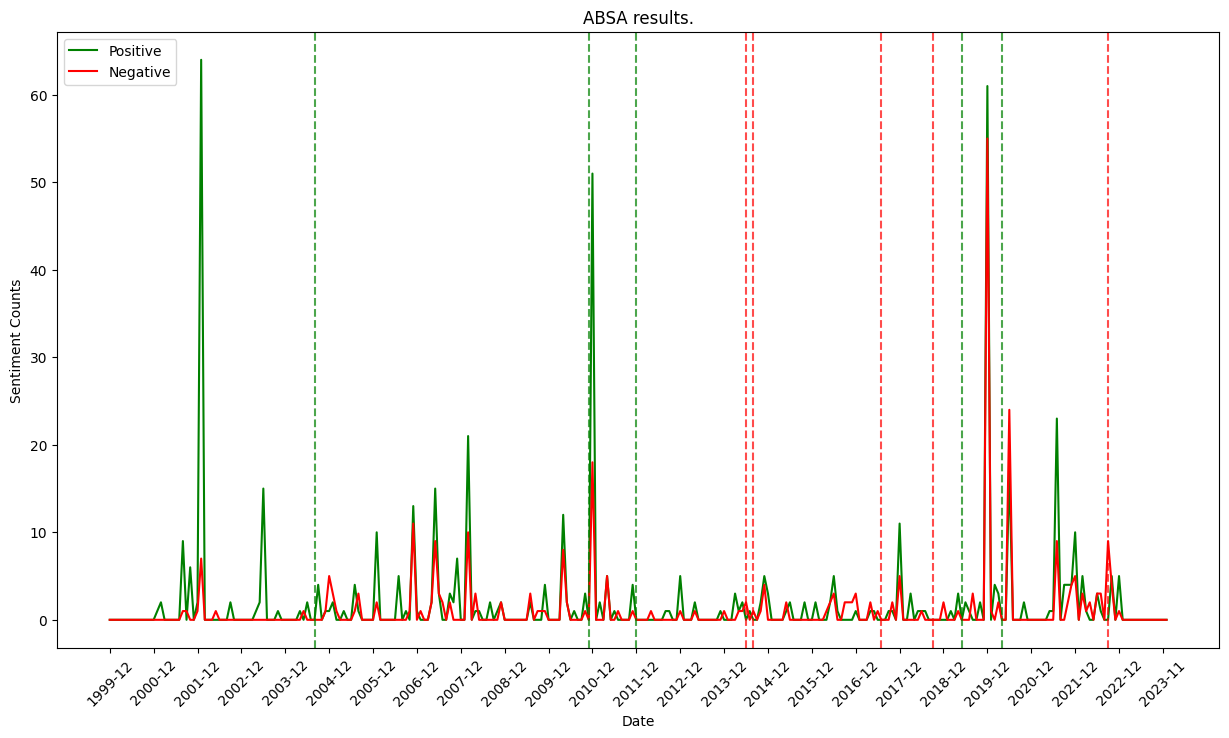

In [46]:
model_pos_preds = positive_model.predict(full_X)
model_neg_preds = negative_model.predict(full_X)

plt.figure(figsize=(15, 8))
plt.plot(chunk_dates, chunk_positive_sentiments, color="green", label="Positive")
plt.plot(chunk_dates, chunk_negative_sentiments, color="red", label="Negative")

for i, val in enumerate(model_pos_preds):
    if val == 1:
        plt.axvline(x=chunk_dates[i], color='green', linestyle='--', alpha=0.7)

for i, val in enumerate(model_neg_preds):
    if val == 1:
        plt.axvline(x=chunk_dates[i], color='red', linestyle='--', alpha=0.7)

plt.xlabel("Date")
plt.ylabel("Sentiment Counts")
plt.legend()
plt.title(f"ABSA results.")
plt.xticks(rotation=45, ticks=range(0, len(chunk_dates), 12))
plt.show()

In [47]:
# Months when positive events occured (data from 1999-2015 was used for model training)
np.array(chunk_dates)[[False] + list(model_pos_preds == 1)]

array(['2004-09', '2010-12', '2012-01', '2019-06', '2020-05'], dtype='<U7')

In [48]:
# Months when negative events occured (data from 1999-2015 was used for model training)
np.array(chunk_dates)[[False] + list(model_neg_preds == 1)]

array(['2014-07', '2014-09', '2017-08', '2018-10', '2022-10'], dtype='<U7')